In [4]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Imports
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# Switching off Brian's C++ code generation (not useful here)
prefs.codegen.target = 'auto'

## Convenience plot functions

In [20]:
# some minor plot tweaks
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False,
                     'lines.linewidth': 2, 'lines.markeredgewidth': 2})

def hh_plot(monitor, idx=0, xlim=None):
    fig, axs = plt.subplots(4, 1, figsize=(12, 6), sharex=True, layout="constrained")
    axs[0].plot(monitor.t/ms, monitor.V[idx]/mV)
    axs[0].set(ylabel='V (mV)')
    axs[1].plot(monitor.t/ms, monitor.I_L[idx]/nA, label=r'$I_\text{L}$')
    axs[1].plot(monitor.t/ms, monitor.I_Na[idx]/nA, label=r'$I_\text{Na}$')
    axs[1].plot(monitor.t/ms, monitor.I_K[idx]/nA, label=r'$I_\text{K}$')
    axs[1].set(ylabel='I (nA)')
    axs[1].legend()
    axs[2].plot(monitor.t/ms, monitor.g_Na[idx]/uS, label=r'$g_\text{Na}$', color='C1')
    axs[2].plot(monitor.t/ms, monitor.g_K[idx]/uS, label=r'$g_\text{K}$', color='C2')
    axs[2].set(ylabel='g (µS)')
    axs[2].legend()
    axs[3].plot(monitor.t/ms, monitor.m[idx], label='$m$')
    axs[3].plot(monitor.t/ms, monitor.h[idx], label='$h$')
    axs[3].plot(monitor.t/ms, monitor.n[idx], label='$n$')
    axs[3].set(ylim=(-0.1, 1.1))
    axs[3].legend()
    axs[3].set_xlabel('t (ms)')
    if xlim is not None:
        axs[3].set_xlim(xlim)

def compare_hh_lif(monitor_hh, monitor_lif, spike_mon_lif, idx=0, xlim=None):
    lif_spikes = spike_mon_lif.spike_trains()[idx]
    fig, axs = plt.subplot_mosaic("""AB
                                     AC""", sharex=True, layout="constrained", figsize=(12, 4))
    axs["A"].plot(monitor_hh.t/ms, monitor_hh.V[idx]/mV, label='HH')
    axs["A"].plot(monitor_lif.t/ms, monitor_lif.V[idx]/mV, label='LIF')
    axs["A"].vlines(lif_spikes/ms, -50, 50, color='C1')  # Plot vertical lines for each spike
    axs["A"].legend()
    axs["A"].set(ylabel='V (mV)', xlabel='t (ms)')

    axs["B"].plot(monitor_hh.t/ms, monitor_hh.V[idx]/mV)
    axs["B"].set(ylabel='V (mV)')

    axs["C"].plot(monitor_lif.t/ms, monitor_lif.V[idx]/mV, color='C1')
    axs["C"].vlines(lif_spikes/ms, -50, 50, color='C1')
    axs["C"].set(ylabel='V (mV)', xlabel='t (ms)')

def compare_fI_curves(I_stim, spike_mon_hh, spike_mon_lif):
    fig, ax = plt.subplots(figsize=(6, 4), layout="constrained")
    ax.plot(I_stim/nA, spike_mon_hh.count, label='HH')
    ax.plot(I_stim/nA, spike_mon_lif.count, label='LIF')
    ax.legend()
    ax.set(xlabel='I (nA)', ylabel='spike count')

## Physical quantities
Brian has a system for physical quantities, handling units and checking for dimensional consistency.

In [10]:
x = 1*mV
y = 2*ms
print(y + x)

DimensionMismatchError: Cannot calculate 2. ms add 1. mV, the units do not match (units are s and V).

## The Hodgkin-Huxley model



<img src="image-20241024-180844.png" width="" align="" />

In [13]:
# Parameters/rate functions are reasonable for a cortical neuron

area = 20000*umetre**2
C = (1*ufarad*cm**-2) * area
g_L = (50*usiemens*cm**-2) * area
VT = -52
E_L = -60*mV
E_K = -90*mV
E_Na = 50*mV
gbar_Na = (100*msiemens*cm**-2) * area
gbar_K = (30*msiemens*cm**-2) * area

# Equations
hh_eqs = """
dV/dt = (I_L + I_Na + I_K + I_stim)/C : volt
I_L = g_L*(E_L - V) : amp
I_Na = g_Na*(E_Na - V) : amp
g_Na = gbar_Na*m**3*h : siemens
I_K = g_K*(E_K - V) : amp
g_K = gbar_K*n**4 : siemens

dn/dt = (n_inf - n)/tau_n : 1
tau_n = 1/(alpha_n + beta_n) : second
n_inf = alpha_n/(alpha_n + beta_n) : 1

dm/dt = (m_inf - m)/tau_m : 1
tau_m = 1/(alpha_m + beta_m) : second
m_inf = alpha_m/(alpha_m + beta_m) : 1

dh/dt = (h_inf - h)/tau_h : 1
tau_h = 1/(alpha_h + beta_h) : second
h_inf = alpha_h/(alpha_h + beta_h) : 1

V_ = V/mV : 1  # for shorter equations below
alpha_m = 0.32*4/exprel((13-V_+VT)/4)/ms : Hz
beta_m = 0.28*5/exprel((V_-VT-40)/5)/ms : Hz
alpha_h = 0.128*exp((17-V_+VT)/18)/ms : Hz
beta_h = 4./(1+exp((40-V_+VT)/5))/ms : Hz
alpha_n = 0.032*5/exprel((15-V_+VT)/5)/ms : Hz
beta_n = .5*exp((10-V_+VT)/40)/ms : Hz
I_stim : amp (constant)
"""

In [16]:
start_scope()

neuron = NeuronGroup(1, hh_eqs, method="exponential_euler")
neuron.V = E_L
neuron.I_stim = 0.5*nA
mon = StateMonitor(neuron, True, record=True)

run(300*ms)

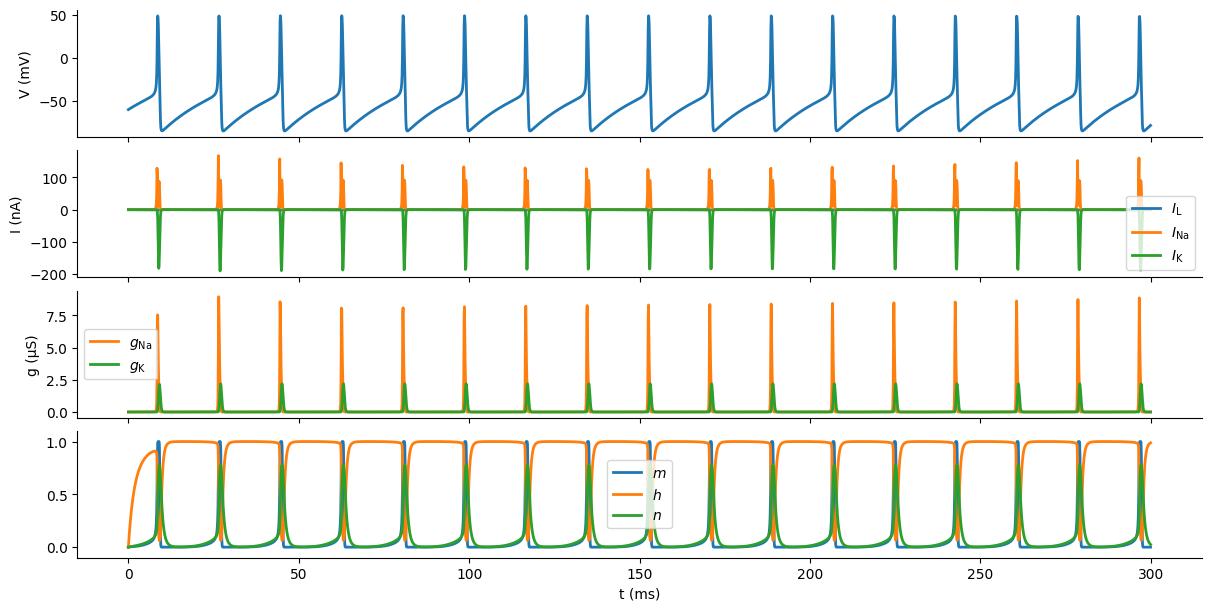

In [23]:
hh_plot(mon)

In [29]:
start_scope()

neuron = NeuronGroup(1, hh_eqs, threshold="V>20*mV", refractory=2*ms, method="exponential_euler")
neuron.V = E_L
neuron.I_stim = 0.5*nA
mon = StateMonitor(neuron, True, record=True)
spike_mon = SpikeMonitor(neuron)
run(300*ms)

In [30]:
print("Number of spikes", spike_mon.count)
print("Inter-spike intervals:", np.diff(spike_mon.t)

SyntaxError: incomplete input (139195683.py, line 2)

## f/I curve (firing rate as function of input)

In [122]:
start_scope()

neuron = NeuronGroup(50, hh_eqs, threshold="V>20*mV", refractory=2*ms, method="exponential_euler")
neuron.V = E_L
neuron.I_stim = np.linspace(0, 1, 50)*nA
mon = StateMonitor(neuron, True, record=True)
spike_mon = SpikeMonitor(neuron)
runtime = 3*second
run(runtime, report="text")

Starting simulation at t=0. s for a duration of 3. s
3. s (100%) simulated in 7s


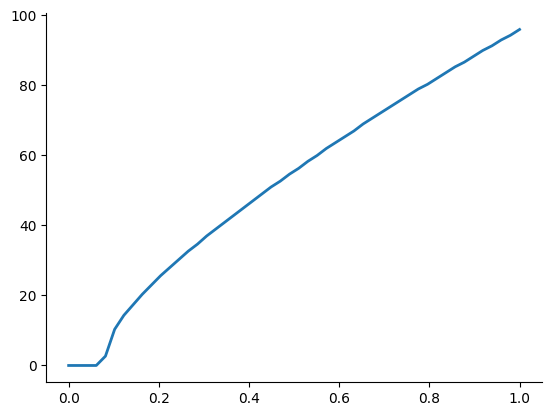

In [126]:
plt.plot(neuron.I_stim/nA, spike_mon.count/runtime);

## The LIF model (leaky integrate-and-fire neuron)

In [33]:
# Equations

prefs.codegen.target = "numpy"
lif_eqs= """
dV/dt = (g_L*(E_L - V) + I_stim)/C : volt
I_stim : amp (constant)
"""

In [36]:
start_scope()
neuron  = NeuronGroup(1, lif_eqs, threshold="V>-50*mV", reset="V=-80*mV", refractory=2*ms, method="exact")
neuron.I_stim = 0.5*nA

mon = StateMonitor(neuron, True, record=True)
spike_mon = SpikeMonitor(neuron)
runtime = 3*second
run(runtime, report="text")

Starting simulation at t=0. s for a duration of 3. s
3. s (100%) simulated in 2s


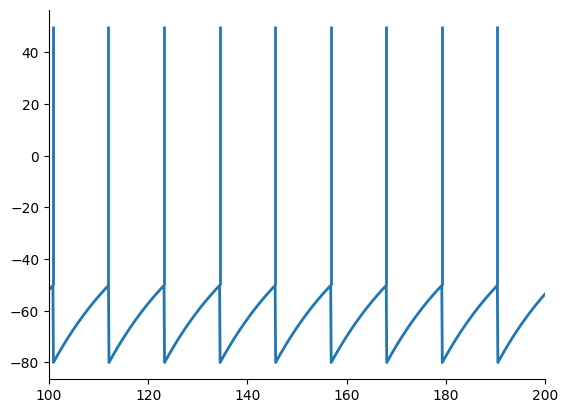

In [37]:
plt.plot(mon.t/ms, mon.V[0]/mV);  plt.xlim(100,  200)
plt.vlines(spike_mon.t/ms,-50, 50)

## Comparing the LIF to the HH model

In [40]:
start_scope()

hh_neurons = NeuronGroup(1, hh_eqs, threshold="V>-20*mV", refractory=5*ms, method='exponential_euler')
hh_neurons.V = E_L
hh_neurons.I_stim = 0.5*nA

neurons = NeuronGroup(1, lif_eqs, threshold="V>-50*mV", reset="V = -70*mV",
                      refractory=2*ms, method='exact')
neurons.V = E_L
neurons.I_stim = 0.5*nA

hh_mon = StateMonitor(hh_neurons, "V", record=True)
mon = StateMonitor(neurons, "V", record=True)
spike_mon = SpikeMonitor(neurons)
run(300*ms)

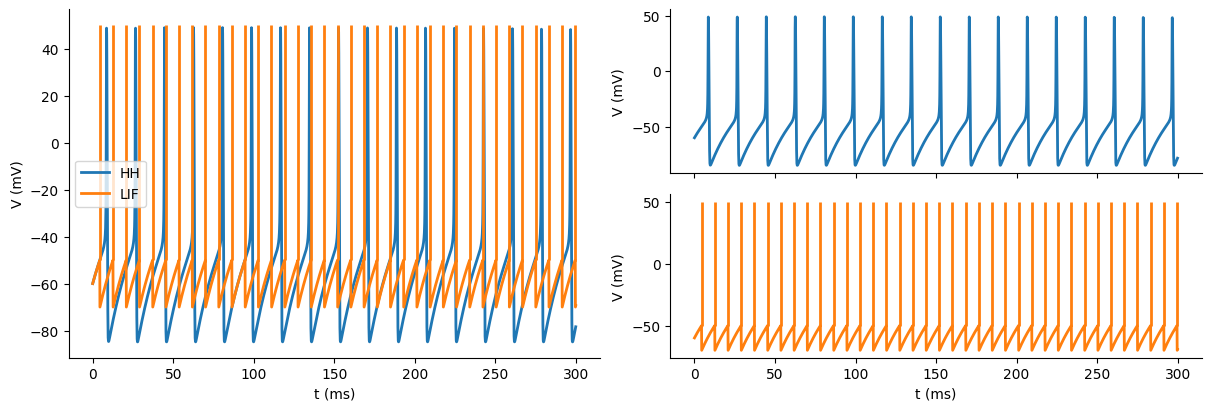

In [41]:
compare_hh_lif(hh_mon, mon, spike_mon)

In [52]:
start_scope()

hh_neurons = NeuronGroup(50, hh_eqs, threshold="V>-20*mV", refractory=5*ms, method='exponential_euler')
hh_neurons.V = E_L
hh_neurons.I_stim = 0.5*nA

neurons = NeuronGroup(50, lif_eqs, threshold="V>-50*mV", reset="V = -70*mV",
                      refractory=2*ms, method='exact')
neurons.V = E_L
neurons.I_stim = np.linspace(0, 1, len(neurons))*nA

hh_mon = StateMonitor(hh_neurons, "V", record=True)
mon = StateMonitor(neurons, "V", record=True)
spike_mon = SpikeMonitor(neurons)
spike_mon_hh = SpikeMonitor(hh_neurons)

run(300*ms)

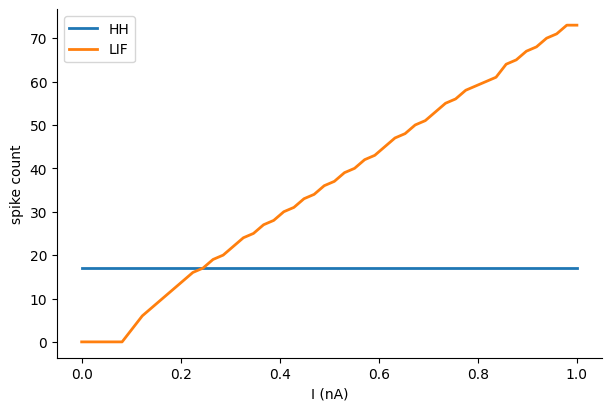

In [53]:
compare_fI_curves(neurons.I_stim, spike_mon_hh, spike_mon)

## Apendix

Best fit for the HH model:
```
threshold="V>-46.36*mV", reset="V = -89.62*mV", refractory=2.43*ms
```

<hr>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7c065da6-9461-4b88-9b62-cc4140a9e456' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>